# Final Project for DTSA-5510

Kevin Juandi <br> 2023-11-25<br> https://github.com/Chiuchiyin/

## Introduction and Problem Description

Welcome to my final project for DTSA-5510! Before running this notebook, please ensure you have all required dependancies installed in your build. All required packages are listed in the next section. If you want to run the code, some parts of the code might take very long time to run. At the time of this writing, I have not attempted to train a model but I expect it to take a couple of hours. Please be patient with it. Thank you for reviewing my project!

For the previous module **DTSA-5509**, I worked on [Heartbeat ECG Classification](https://github.com/Chiuchiyin/Heartbeat-ECG-Classification). I would like to expand my repetoire in health analytics and have decided to work on Pneumonia Classification.

The data I will use can be found at Mendeley Data[<sup>[1]</sup>](https://data.mendeley.com/datasets/rscbjbr9sj/3). The data contain images of both chest X-Rays and Optical Coherence Tomography. The original paper uses deep learning algorithm which I would not attempt to replicate due to computational requirements. I will just use the chest X-rays in this project. I have included the data in the Github Repository so if you decided to download the data so you don't have to download the entire dataset and extract them yourself.

The chest X-ray data in "train" contains 1.18 GB of data - consisting of 1349 "normal" chest X-rays, 1345 X-rays with viral pneumonia, and 2538 X-rays with bacterial pneumonia. The "test" data contains 105 MB of data - there are 234 "normal" chest X-rays, 148 with viral pneumonia, and 242 with bacterial pneumonia.

## Loading dependancies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv
import matplotlib.pyplot as plt
import os
import math
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
import time
import itertools
import random
from collections import Counter
%matplotlib inline

## Helper functions
We would use these functions to reduce clutter

In [2]:
def readXRay(path, pixDesired = 1000, n_imgs = "use all"):
    """
        input: string path, of form ("./data/ os.listdir(parent directory)
        input: int pixDesired, the number of pixels pixDesired X pixDesired in which to read the data. If None, no transformation is performed.
        input: int n_imgs, number of images to be read from file. Preset is string "use all", which uses all the images in the provided path.
        output: np.ndarray data
    """
    
    # Initialize data
    firstImagePath = path + os.listdir(path)[0]
    firstPic = cv.imread(firstImagePath, 0)
    if pixDesired != None:
        data = cv.resize(firstPic, (pixDesired, pixDesired))
        data = data.reshape(1, pixDesired ** 2)# If performance allows, increase resize!
    else:
        data = data.reshape(1, firstPic.shape[0] * firstPic.shape[1])
    
    # Populate data
    
    if n_imgs == "use all":
        for img in os.listdir(path)[1:]:
            filepath = path + img
            pic = cv.imread(filepath, 0)
            if pixDesired != None:
                pic = cv.resize(pic, (pixDesired, pixDesired))
                pic = pic.reshape(1, pixDesired ** 2)
            else:
                pic = pic.reshape(1, pic.shape[0] * pic.shape[1])
            
            data = np.append(data, pic, axis = 0)
            
    else:
        for img in os.listdir(path)[1:n_imgs]:
            filepath = path + img
            pic = cv.imread(filepath, 0)
            if pixDesired != None:
                pic = cv.resize(pic, (pixDesired, pixDesired)) # If performance allows, increase resize!
                pic = pic.reshape(1, pixDesired ** 2)
            else:
                pic = pic.reshape(1, pic.shape[0] * pic.shape[1])
            
            data = np.append(data, pic, axis = 0)
        
    return(data)

## Load the Data and Perform EDA
### Loading the Data

In [3]:
%cd ".\chest_xray"

os.listdir()

C:\Users\silve\OneDrive\Dokumente\Github\DTSA5510-Unsupervised-Learning-Final-Project\chest_xray


['reducedData.csv', 'test', 'train']

In [4]:
# Example XRay. Citation https://www.geeksforgeeks.org/python-opencv-cv2-imshow-method/
# Set file path
startTime = time.time()
repopath = "./train/" + "NORMAL/"
filepath = repopath + os.listdir(repopath)[0]

#Read in test image
testpic = cv.imread(filepath, 0)
#testpic = cv.resize(testpic, (256, 256))

endTime = time.time()

##Show test image
testWindow = "Example XRAY. This is a healthy lung."
cv.imshow(testWindow, testpic)
cv.waitKey(0)  #Wait for the user to press a key before closing the window
cv.destroyAllWindows() 

print(testpic.shape)
print(endTime - startTime)

(2476, 2572)
0.09709739685058594


From running the code above, we could see that the images are particularly large but are they all in the same size? Let us check the size of the next image.

In [8]:
filepath1 = repopath + os.listdir(repopath)[1]
testpic1 = cv.imread(filepath1, 0)
print(testpic1.shape)

(1751, 1982)


This confirms that not all of the images are the same dimension. We would therefore need to resize the images to the same size. to do this, we use the pixDesired option to standardize the images to a square of desired size. For computational reason, we set the auto selection of 1000 pixels per image.

In [5]:
# Set up paths of repositories to read data from
paths = ["./train/NORMAL/", "./train/VIRAL/", "./train/BACTERIAL/", 
         "./test/NORMAL/", "./test/VIRAL/", "./test/BACTERIAL/"]

In [16]:
#Initialize data
firststartTime = time.time()
data = readXRay(path = paths[0], pixDesired = 100, n_imgs = "use all")
firstendTime = time.time()
print(firstendTime - firststartTime) #How long did this repo take to convert?
print(data.shape) #How many files in this repo?

#Populate data with the other repositories
for path in paths[1:]:
    startTime = time.time()
    this_data = readXRay(path = path, pixDesired = 100, n_imgs = "use all")
    endTime = time.time()

    print(endTime - startTime) #How long did this repo take to convert?
    print(this_data.shape) #How many files in this repo?
    data = np.append(data, this_data, axis = 0)

print(endTime - firststartTime)
print(data.shape)

20.751718282699585
(1349, 10000)
7.880717754364014
(1345, 10000)
17.327439308166504
(2538, 10000)
2.386894702911377
(234, 10000)
0.5994760990142822
(148, 10000)
0.6994566917419434
(242, 10000)
49.6903555393219
(5856, 10000)


In [17]:
# Records 3 class labels in np.ndarray
Normal1 = np.asarray(["NORMAL" for i in range(1349)])
Viral1 = np.asarray(["VIRAL" for i in range(1345)])
Bacterial1 = np.asarray(["BACTERIAL" for i in range(2538)])
Normal2 = np.asarray(["NORMAL" for i in range(234)])
Viral2 = np.asarray(["VIRAL" for i in range(148)])
Bacterial2 = np.asarray(["BACTERIAL" for i in range(242)])
labs = np.append(Normal1, Viral1, axis = 0)
labs = np.append(labs, Bacterial1, axis = 0)
labs = np.append(labs, Normal2, axis = 0)
labs = np.append(labs, Viral2, axis = 0)
labs = np.append(labs, Bacterial2, axis = 0)

assert labs.shape[0] == data.shape[0]

print(labs.shape)

(5856,)


In [18]:
# Records 2 class labels in np.ndarray
Infected1 = np.asarray(["INFECTED" for i in range(1345 + 2538)])
Infected2 = np.asarray(["INFECTED" for i in range(148 + 242)])

labs2 = np.append(Normal1, Infected1, axis = 0)
labs2 = np.append(labs2, Normal2, axis = 0)
labs2 = np.append(labs2, Infected2, axis = 0)

assert labs2.shape[0] == data.shape[0]

print(labs2.shape)

(5856,)


Using pixDesired = 100 resulted in a total data reading time of roughly 46 seconds. Using pixDesired = 500 resulted in a total time of 320 seconds. An interesting extension to the project would be measuring accuracy vs. pixDesired over perhaps an order of magnitude of pixDesired. With the 500 pixDesired, we would need an extra 10 GB of RAM to run the NMF, which is way too much. I'll stick with pixDesired = 100 for now and probably try larger value later. Note that this will severly damage accuracy.

### PCA
We would then perform PCA to reduce the data to more manageable size.

In [19]:
#Perform PCA. We will use a minimum explained variance of 0.98 so as to prevent inhibiting our models from successfully categorizing the X-Rays
min_var_explained = 0.98
pca = PCA(n_components = min_var_explained, svd_solver = "full")

startTime = time.time()
reducedData = pca.fit_transform(data)
endTime = time.time()

# Print result summary
print(endTime - startTime)
print(reducedData.shape)

182.06255674362183
(5856, 1533)


In [20]:
#Write the resulting data to a csv so that we don't need to process it again in future analysis
startTime = time.time()
np.savetxt("reducedData.csv", reducedData, delimiter=",")
endTime = time.time()
print(endTime - startTime)

5.357702732086182


### EDA
We would now do some basic EDA on the reduced data

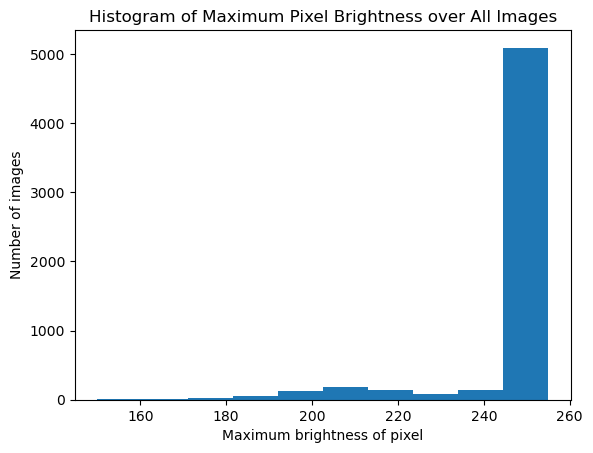

In [21]:
# Make histogram of max values
maxes = list(np.max(data, axis = 1))
plt.hist(maxes)
plt.xlabel("Maximum brightness of pixel")
plt.ylabel("Number of images")
plt.title("Histogram of Maximum Pixel Brightness over All Images")
plt.show()

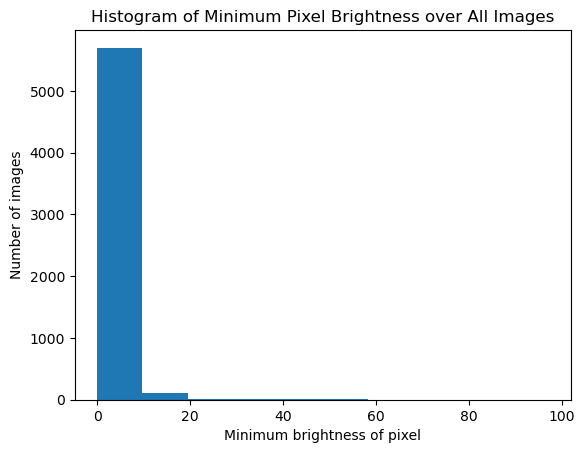

In [22]:
mins = np.min(data, axis = 1)
plt.hist(mins)
plt.xlabel("Minimum brightness of pixel")
plt.ylabel("Number of images")
plt.title("Histogram of Minimum Pixel Brightness over All Images")
plt.show()

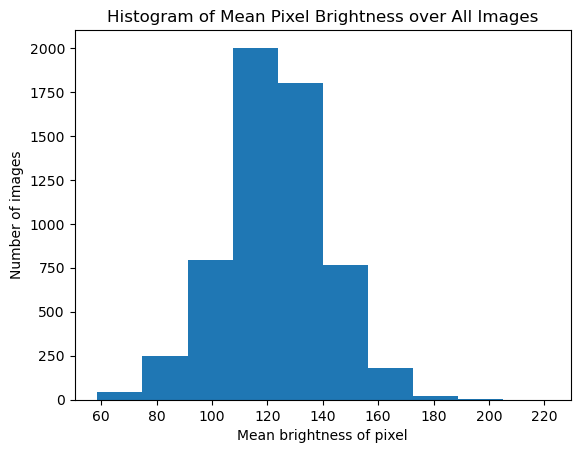

In [23]:
means = np.mean(data, axis = 1)
plt.hist(means)
plt.xlabel("Mean brightness of pixel")
plt.ylabel("Number of images")
plt.title("Histogram of Mean Pixel Brightness over All Images")
plt.show()